In [131]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.metrics import r2_score

## ORDER ROUTING FUNCTIONAL APPROXIMATION

# Notation
Question 1
$$
\begin{aligned}
&\textbf{Approximation under the greedy fill approach:} \\

&x_i = \min\left(N_i,\ \left|T - \sum_{k=0}^i N_k\right|\right) \\

&S_B(T, t) = \frac{1}{T} \cdot \sum_i x_i (P_i - s_t) \\
&\phantom{S_B(T, t)} = \frac{1}{T} \cdot \sum_i \min\left(N_i,\ \left|T - \sum_{k=0}^i N_k\right|\right) \cdot (P_i - s_t) \\
&\phantom{S_B(T, t)} = \frac{1}{T} \cdot \sum_i \min\left(N_i \cdot (P_i - s_t),\ \left|T - \sum_{k=0}^i N_k\right| \cdot (P_i - s_t)\right) \\

&\text{Assume } x_i \text{ is the volume filled at each time frame, subject to:} \\
&\sum_{i=0}^N x_i = T, \quad x_i \ge 0, \quad C_{i+1} = C_i + 0.01 \text{ where } C = P_i - s_t \\

&\text{Then, the slippage function } S_B(T, t) \text{ at a fixed time } t \text{ becomes:} \\
&S_B(T, t) \approx \frac{1}{T} \sum_{i=0}^N \left(C + \frac{i}{100}\right) x_i \\

&\text{Since } s_t \text{ is constant at fixed time } t, \\
&S_B(T, t) = \frac{1}{T} \cdot \sum_{i=0}^N \left(C \cdot x_i + \frac{i \cdot x_i}{100}\right) \\
&\phantom{S_B(T, t)} = C + \frac{1}{T} \sum_{i=0}^N \frac{i x_i}{100} \\

&\text{If } x_i \text{ is constant, then } \sum_{i=0}^N i \cdot x_i \propto T \Rightarrow S_B(T, t) \approx A \cdot T + c \\

&\text{A linear approximation suffices only if } x_i \text{ is constant.} \\
&\text{Since this may not hold, a better model } x_i \approx \alpha T^\beta \text{ is preferable.}
\end{aligned}
$$





In [132]:
test_stat = pd.DataFrame({"Price": [81.00, 80.99,80.97,80.96,80.95,80.93,80.92,80.91], "Ask": [140,123,110,0,0,0,0,0], "Bid": [0,0,0,0,0,112,138,200]})

## Functions


$$
g_t = \alpha \cdot x^{\beta} \\ 
l_t = \alpha \cdot X + \beta \\

g^*_t = \text{Actual slippage model under the greedy filled algorithm}

$$

In [133]:
def slippage_model(a,b,x):
    return a * x ** b

def linear_test(a,b,x):
   return a * x  + b

def slippage(df, mid_price, T, side="Buy"):
  initial_T = T
  if side == "Buy":
    data = df[df["Ask"] > 0][["Price", "Ask"]].iloc[::-1].reset_index(drop=True)
  else:
    data = df[df["Bid"] > 0][["Price", "Bid"]].reset_index(drop=True)
  slippage = 0
  i = 0
  size = len(data)
  while T > 0 and i < size:
    price = data.iloc[i, 0]
    volume = min(T, data.iloc[i, 1]) 
    if side == "Buy":
      slippage += min(T, volume) * (price - mid_price)
    else:
      slippage += min(T, volume) * (mid_price - price)
    T -= volume
    i += 1
  return slippage / initial_T


def clean_df(databent):
    data = pd.DataFrame(columns = ["Price",  "Ask", "Bid"])
    for i in range(9):
        data.loc[2*i, ["Price", "Ask", "Bid"]] = [databent[f"ask_px_0{i}"], databent[f"ask_sz_0{i}"], 0]
        data.loc[2*i+1, ["Price", "Ask", "Bid"]] = [databent[f"bid_px_0{i+1}"], 0, databent[f"bid_sz_0{i+1}"]] 


    data = data.sort_values(by="Price").iloc[::-1].reset_index(drop=True)
    midprice = round((data[data["Ask"] > 0].iloc[-1, 0] + data[data["Bid"] > 0].reset_index(drop=True).iloc[0,0]) / 2 , 2)
    return data, midprice 

def combined_statistic_df(df, max_orders, step, side="Buy"):
    x = [t for t in range(1000, max_orders, step)]
    
    # Initialize dictionaries to store data for both DataFrames
    data_statistic = {"Features": x}
    data_log_statistic = {"Features": np.log(x)}  # Logarithmic values for x
    
    for j in range(len(df)):
        column_name = f"t_{j}"
        
        y_statistic = [slippage(*clean_df(df.iloc[j, :]), t, side) for t in x]
        data_statistic[column_name] = y_statistic
        
        y_log_statistic = [np.log(slippage(*clean_df(df.iloc[j, :]), t, side)) for t in x]
        data_log_statistic[column_name] = y_log_statistic
    
    stats_df = pd.DataFrame(data_statistic)
    log_stats_df = pd.DataFrame(data_log_statistic)
    return log_stats_df, stats_df
   




In [134]:
def Slippage_plot(df, mid_price, max, step, side="Buy"):
    X = range(1, max, step)
    Y = [float(slippage(df, mid_price, t, side)) for t in X]
    plt.figure(figsize=(12, 6))
    plt.title("Buy Side")
    plt.xlabel("Order Size")
    plt.ylabel("Slippage")
    plt.plot(X, Y, color="Green")
    plt.show()

In [135]:
df = pd.read_csv("C:/Users/victo/Documents/Coding_Projects/BlockHouse/SOUN/SOUN_2025-04-03 00_00_00+00_00.csv")

In [136]:
new_df = df.iloc[10000, :]

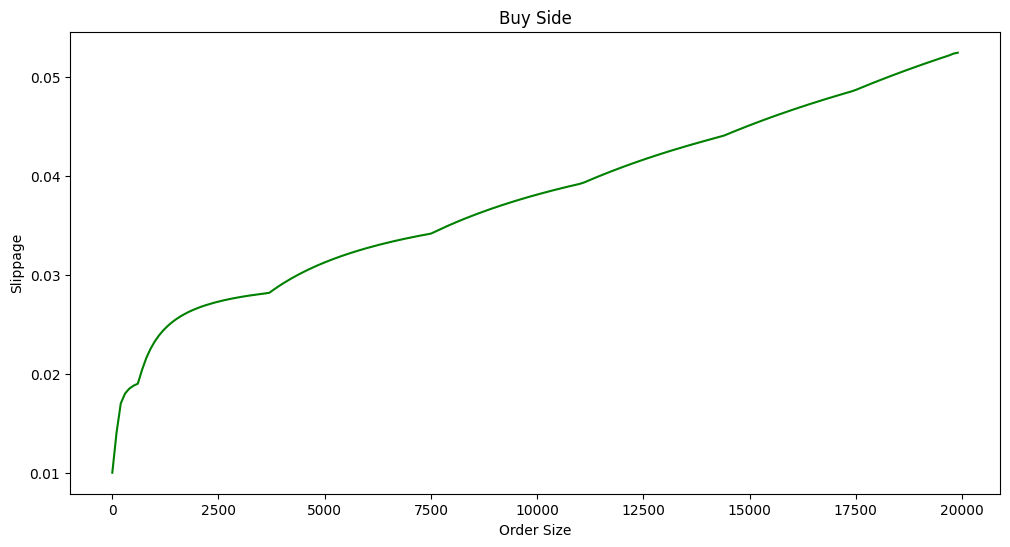

In [137]:
Slippage_plot(*clean_df(new_df) ,20000, 100)

In [151]:
# Sample regression data 
regression_data = df.iloc[1000:2000, :]

In [139]:
train_data,test_data = combined_statistic_df(regression_data, 5000, 50, "Buy")

In [152]:
power_model = np.polyfit(train_data["Features"], train_data["t_7"], 1)
linear_model = np.polyfit(test_data["Features"], test_data["t_7"], 1)

In [153]:
alpha_power = np.exp(power_model[1])
beta_power = power_model[0]
alpha_linear = linear_model[0]
beta_linear = linear_model[1]

In [154]:
#Sample parameters
print(alpha_power)
print(beta_power)
print(alpha_linear)
print(beta_linear)

0.0038955846947326435
0.27833246823530405
3.719936005715007e-06
0.024415454353546234


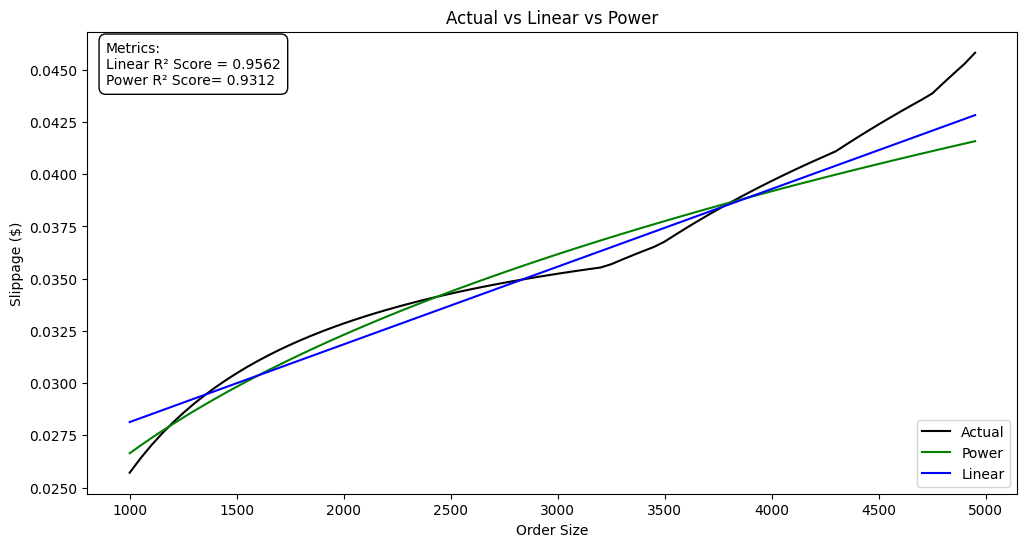

In [155]:
X = test_data["Features"]
plt.figure(figsize=(12,6))
plt.title("Actual vs Linear vs Power")
plt.xlabel("Order Size")
plt.ylabel("Slippage ($)")
plt.plot(X, test_data["t_0"], color="black", label="Actual")
plt.plot(X, slippage_model(alpha_power, beta_power, X), color="green", label="Power")
plt.plot(X, linear_test(alpha_linear, beta_linear, X), color="blue", label="Linear")
metrics_text = f"""Metrics:\nLinear R² Score = {r2_score(test_data["t_0"], 
               linear_test(alpha_linear, beta_linear, X)):.4f}\nPower R² Score= {r2_score(test_data["t_0"],
               slippage_model(alpha_power, beta_power, X)):.4f}"""
plt.text(
        0.02, 0.98, metrics_text, transform=plt.gca().transAxes,
        fontsize=10, color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"),
        verticalalignment='top', horizontalalignment='left'
    )
plt.legend()

In [156]:
def regression_stats(df, max, step, side="Buy"):
    train_data, test_data = combined_statistic_df(regression_data, max, step, "Buy")
    linear_stats = []
    power_stats = []
    X = np.array(test_data["Features"])
    for i in range(len(df)):
        power_model = np.polyfit(train_data["Features"], train_data[f"t_{i}"], 1)
        linear_model = np.polyfit(X, test_data[f"t_{i}"], 1)

        alpha_power = np.exp(power_model[1])
        beta_power = power_model[0]
        alpha_linear = linear_model[0]
        beta_linear = linear_model[1]
        
        linear = r2_score(test_data[f"t_{i}"], linear_test(alpha_linear, beta_linear, X))
        power = r2_score(test_data[f"t_{i}"], slippage_model(alpha_power, beta_power, X))
        linear_stats.append(linear)
        power_stats.append(power)
    
    plt.figure(figsize=(10, 5))
    sns.kdeplot(linear_stats, label="Linear R² Score", fill=True, linewidth=2)
    sns.kdeplot(power_stats, label="Power R² Score", fill=True, linewidth=2)
    plt.title("Distribution of R² Scores")
    plt.xlabel("R² Score")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return True


### Distribution Comparison of the R^2 Scores over various time steps

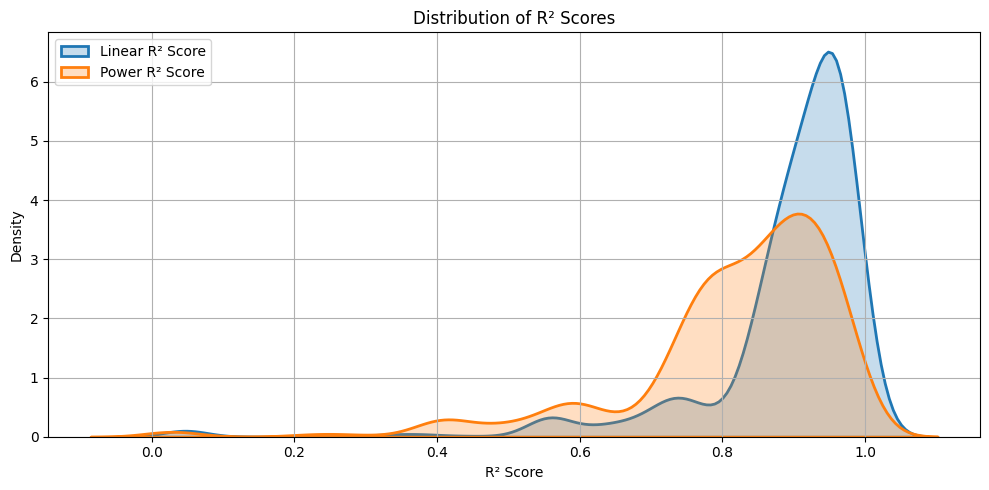

True

In [157]:
regression_stats(regression_data, 5000, 50, "Buy")

### Dynamic Optimal Execution Algorithm

$$
\begin{aligned}
\text{Define the value function: } \\

V_t(R) = \min_{0 \le x \le R} \left[g_t(x) + V_{t+1}(R - x)\right] \\

\text{with } V_{N+1}(0) = 0 \text{ and } V_{N+1}(R > 0) = \infty. \\
\text{Using the power-law form: } \\
V_t(R) = \min_{0 \le x \le R} \left[a_t x^{\beta} + V_{t+1}(R - x)\right]
\end{aligned}
$$

In [146]:

def dynamic_portfolio_algorithm(g, N,Shares, R_grid = None, beta = 1.0):
    if R_grid is None:
        R_grid = np.linspace(0, Shares, max(100, 10*N))
    V = {}
    optimal_x = {} 
    
    V[N+1] = {}
    for i, R in enumerate(R_grid):
        if R > 0:
            V[N+1][i] = float('inf')
        else:
            V[N+1][i] = 0.0         

    for t in range(N, 0, -1):  
        V[t] = {}
        optimal_x[t] = {}
        
        for r_idx, R in enumerate(R_grid): 
            min_value = float('inf')
            best_x = 0.0
            
            x_candidates = R_grid[R_grid <= R]  
            
            for x in x_candidates:
                remaining_resources = R - x
                closest_idx = np.argmin(np.abs(R_grid - remaining_resources))
                cost = g(x) * beta + V[t+1][closest_idx]
                
                if cost < min_value:
                    min_value = cost
                    best_x = x
            
            V[t][r_idx] = min_value
            optimal_x[t][r_idx] = best_x
    
    optimal_purchases = []
    current_resources = Shares
    
    for t in range(1, N+1):
        r_idx = np.argmin(np.abs(R_grid - current_resources))
        x_optimal = optimal_x[t][r_idx]
        optimal_purchases.append(x_optimal)
        current_resources -= x_optimal
        current_resources = max(0, current_resources)
    return optimal_purchases

In [147]:
optimal_shares = dynamic_portfolio_algorithm(lambda x : slippage_model(alpha_power, beta_power, x), 30, 1000)

In [149]:
Shares = 1000

In [150]:
print("Optimal share purchases at each time step:")
for t, shares in enumerate(optimal_shares, 1):
    print(f"Time {t}: Buy {shares:.4f} shares")
    
print(f"\nTotal shares purchased: {sum(optimal_shares):.4f}")
print(f"Resources remaining: {Shares - sum(optimal_shares):.4f}")

Optimal share purchases at each time step:
Time 1: Buy 0.0000 shares
Time 2: Buy 0.0000 shares
Time 3: Buy 0.0000 shares
Time 4: Buy 0.0000 shares
Time 5: Buy 0.0000 shares
Time 6: Buy 0.0000 shares
Time 7: Buy 0.0000 shares
Time 8: Buy 0.0000 shares
Time 9: Buy 0.0000 shares
Time 10: Buy 0.0000 shares
Time 11: Buy 0.0000 shares
Time 12: Buy 0.0000 shares
Time 13: Buy 0.0000 shares
Time 14: Buy 0.0000 shares
Time 15: Buy 0.0000 shares
Time 16: Buy 0.0000 shares
Time 17: Buy 0.0000 shares
Time 18: Buy 0.0000 shares
Time 19: Buy 0.0000 shares
Time 20: Buy 0.0000 shares
Time 21: Buy 0.0000 shares
Time 22: Buy 0.0000 shares
Time 23: Buy 0.0000 shares
Time 24: Buy 0.0000 shares
Time 25: Buy 0.0000 shares
Time 26: Buy 0.0000 shares
Time 27: Buy 0.0000 shares
Time 28: Buy 0.0000 shares
Time 29: Buy 0.0000 shares
Time 30: Buy 1000.0000 shares

Total shares purchased: 1000.0000
Resources remaining: 0.0000
